<a href="https://colab.research.google.com/github/FrodoBaggins87/Machine_Learning/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Making all important imports and copy pasting data_setup.py and engine.py from Custom Datasets(going_modular) project file

In [67]:
#we need Torch 1.12 + and Torchvision 0.13 + for this study
try:
  import torch, torchvision
  assert int(torch.__version__.split(".")[1])>=12, "Torch version should be 1.12 or above"
  assert int(torchvision.__version__.split(".")[1])>=13, "Torch version should be 0.12 or above"
  print(f"Torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")
except:
  print("Available libraries not updated, downloading updated libraries")
  !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
  import torch, torchvision
  print(f"Torch version:{torch.__version__}")
  print(f"torchvision version:{torchvision.__version__}")

Available libraries not updated, downloading updated libraries
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Torch version:2.3.0+cu121
torchvision version:0.18.0+cu121


In [68]:
%%writefile data_setup.py
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

NUM_WORKERS= os.cpu_count()
def create_dataloaders(
    train_dir: str,
    test_dir:str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size:int,
    num_workers: int=NUM_WORKERS
):

  training_data=datasets.ImageFolder(root=train_dir, transform=train_transform)
  testing_data=datasets.ImageFolder(root=test_dir, transform=test_transform)
  class_names=training_data.classes
  train_dataloader=DataLoader(dataset=training_data,
                              batch_size=batch_size,#sample per dataloader
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory= True)
  test_dataloader=DataLoader(dataset=testing_data,
                            batch_size=batch_size,
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory= True)
  return train_dataloader, test_dataloader, class_names


Overwriting data_setup.py


In [69]:
%%writefile engine.py
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
              device: torch.device) -> Tuple[float, float]:
  #putting in training mode
  model.train()
  #setup training loss and training accuracy
  train_loss,train_acc=0,0

  for batch,(x,y) in enumerate(dataloader):
    #send data to target device
    x,y=x.to(device),y.to(device)
    #forward pass
    y_pred=model(x)
    #calculate and accumulate losses
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()
    #optimizer zero grad
    optimizer.zero_grad()
    #loss backward
    loss.backward()
    #optimizer step
    optimizer.step()

    #calculate and accumulate accuracy metric for all batches
    y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc+=(y_pred_class==y).sum().item()/len(y_pred)

  #getting average loss and accuracy for each batch
  train_loss/=len(dataloader)
  train_acc/=len(dataloader)
  return train_loss, train_acc

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
              device: torch.device) -> Tuple[float,float]:
  #putting in eval mode
  model.eval()
  #setup test loss and test accuracy
  test_loss,test_acc=0,0
  #turn on inference context manager
  with torch.inference_mode():
    #loop through dataloader batches
    for batch,(x,y) in enumerate(dataloader):
      #send data to target device
      x,y=x.to(device),y.to(device)
      #forward pass
      test_pred_logits=model(x)
      #calculate and accumulate loss
      loss=loss_fn(test_pred_logits,y)
      test_loss+=loss.item()
      #calculate and accumulate accuracy
      test_pred_labels=torch.argmax(torch.softmax(test_pred_logits,dim=1),dim=1)
      test_acc+=(test_pred_labels==y).sum().item()/len(test_pred_labels)#can probably also use len(test_pred), not sure both should work i think
  #getting average loss and accuracy for each batch
  test_acc/=len(dataloader)
  test_loss/=len(dataloader)
  return test_loss, test_acc

#defining functions and various required parameters
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          epochs: int,
        device: torch.device) -> Dict[str, list]:
  #create empty results dictionary
  results={"train_loss":[],
           "test_loss":[],
           "train_acc":[],
           "test_acc":[]}
  #looping through train_step() and test_step()
  for epoch in tqdm(range(epochs)):
    train_loss,train_acc=train_step(model=model,
                                    dataloader=train_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    device=device)
    test_loss, test_acc=test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device)
  #print whats happening
    print(
        f"Epoch:{epoch+1}|"
        f"Train Loss:{train_loss:.4f}|"
        f"Training Accuracy: {train_acc:.4f}|"
        f"Test Loss: {test_loss:.4f}|"
        f"Test Accuracy: {test_acc:.4f}"
    )
    #updating result dictionary
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)
    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)
  return results


Overwriting engine.py


In [70]:
!pip install -q torchinfo


In [71]:
#making rest of the imports
import matplotlib.pyplot as plt
import torch, torchvision
from torch import nn
from torchvision import transforms

#trying to get torchinfo
try:
  from torchinfo import summary
except:
  print("Couldnt find torchinfo... installing it")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  import data_setup, engine
except:
  print("")

In [72]:
#setup device agnostic code
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Getting data (same data as used in Custom Datasets project)

In [73]:
import requests
import zipfile
from pathlib import Path
import os
#setup path to data folder
data_path= Path("data/")
image_path=data_path/"food_stuff"
#check if image folder exists or not, if not prepare it
if image_path.is_dir():
  print(f"{image_path} directory exists")
else:
  print(f"Didnt find {image_path}, creating...")
  image_path.mkdir(parents=True, exist_ok=True)
  #the datset that will be used is a formatted dataset being taken from a github file, in general, wont get such formatted data
  #download pizza, steak, sushi data in zip file
  with open(data_path/"food_stuff.zip","wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading data...")
    f.write(request.content)
  #unzip data
  with zipfile.ZipFile(data_path/"food_stuff.zip","r") as zip_ref:
    print("Unzipping food_stuff file...")
    zip_ref.extractall(image_path)


data/food_stuff directory exists


In [74]:
#creating paths to train and test directories
train_dir=image_path/"train"
test_dir=image_path/"test"


Create Datasets and Dataloaders

manually creating transforms

In [75]:
#Firstly need to transform images to fit into the model
manual_transforms=transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])
                                      ])

In [76]:
#create ("MANUALLY") dataloaders using function from data_setup.py
train_dataloader, test_dataloader, class_names= data_setup.create_dataloaders(train_dir=train_dir,
                                                                             test_dir=test_dir,
                                                                             train_transform=manual_transforms,
                                                                             test_transform= manual_transforms,
                                                                             batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7811322a6fe0>,
 ['pizza', 'steak', 'sushi'])

Can also create transforms manually

In [77]:
#get a set of pretrained weights
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT #DEFAULT gives the best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [78]:
#Get transform used to create our pretrained weights
auto_transform=weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [79]:
#now, can use auto_transform to create dataloaders
train_dataloader, test_dataloader, class_names= data_setup.create_dataloaders(train_dir=train_dir,
                                                                             test_dir=test_dir,
                                                                             train_transform=manual_transforms,
                                                                             test_transform= manual_transforms,
                                                                             batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x781132235900>,
 ['pizza', 'steak', 'sushi'])

Loading pretrained model

In [80]:
#load weights of pretrained model
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
model=torchvision.models.efficientnet_b0(weights=weights).to(device)

In [81]:
#print summary from torchinfo
try:
  import torchinfo
except:
  !pip install torchinfo


from torchinfo import summary
summary(model=model,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

Freezing the base model and customizing output layer

In [82]:
#we only need to change the output layer according to our problem of classification into 3 objects
#we will try to only change the output layer and then train that part only while letting rest of the parameters be as they are
#this way we can use the output of the base model which is already trained on a very big dataset and train few of the parameters oally to customize the entire model for our problem
#this will take significantly less computational power as compared to training whole of the model with few millions of parameters
#freeze the parameters of the base model means they wont change in values and cant be trained to do that put requires_grad=False

In [83]:
for param in model.features.parameters():#the feature extraction layers of the model is called features, see above in summary
  param.requires_grad=False

In [84]:
#change the output layer
torch.manual_seed(64)
torch.cuda.manual_seed(65)

#length of class names
output_shape=len(class_names)
model.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), #Dropout layer is used to randomly drop p out of 1 connections out of all the connections between layers of neural network
    torch.nn.Linear(in_features=1280,#same as original model
                    out_features=output_shape,
                    bias=True)).to(device)

In [85]:
#summarize the customized model
#look at the total parameters and the trainable parameters
summary(model=model,
        input_size=(32,3,224,224),
        verbose=0,#why is this 0
        col_names=["input_size", "output_size", "num_params", "trainable"],#see documentation for all available column names to be displayed
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

Train the new Model

In [86]:
#Define loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)


In [87]:
#set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(4343)
import engine
#start timer
from timeit import default_timer as timer
start_time=timer()

#setup training
results= engine.train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               epochs=10,
               device=device)
#end timer and print how long it took
end_time=timer()
print(f"Total training time:{end_time-start_time} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch:1|Train Loss:1.0770|Training Accuracy: 0.4297|Test Loss: 0.8927|Test Accuracy: 0.7216
Epoch:2|Train Loss:0.8597|Training Accuracy: 0.7734|Test Loss: 0.7992|Test Accuracy: 0.8040
Epoch:3|Train Loss:0.7579|Training Accuracy: 0.8359|Test Loss: 0.7525|Test Accuracy: 0.8049
Epoch:4|Train Loss:0.7182|Training Accuracy: 0.7539|Test Loss: 0.6541|Test Accuracy: 0.9072
Epoch:5|Train Loss:0.6269|Training Accuracy: 0.8008|Test Loss: 0.6381|Test Accuracy: 0.8551
Epoch:6|Train Loss:0.5698|Training Accuracy: 0.9180|Test Loss: 0.5674|Test Accuracy: 0.8864
Epoch:7|Train Loss:0.4960|Training Accuracy: 0.9336|Test Loss: 0.5462|Test Accuracy: 0.8864
Epoch:8|Train Loss:0.5447|Training Accuracy: 0.8203|Test Loss: 0.5516|Test Accuracy: 0.8551
Epoch:9|Train Loss:0.5482|Training Accuracy: 0.7891|Test Loss: 0.5039|Test Accuracy: 0.9280
Epoch:10|Train Loss:0.4755|Training Accuracy: 0.8008|Test Loss: 0.4399|Test Accuracy: 0.8655
Total training time:29.44456041600006 seconds


Plotting loss curves

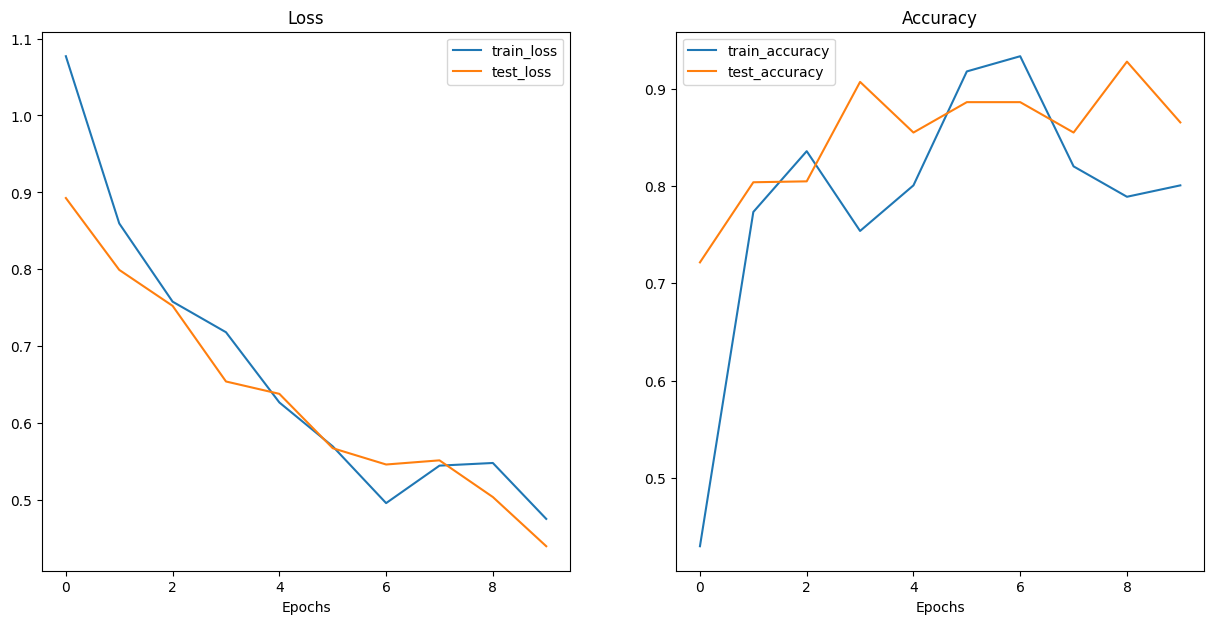

In [88]:
#Using helper_functions.py file from github
try:
  from helper_functions import plot_loss_curves
except:
  print("downloading helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    import requests
    request=requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

plot_loss_curves(results)

Make prediction on a particular image using the model

In [89]:
from PIL import Image

#define a function which takes in an image and the trained model applies required transformation and plots the image and writes the class and the probability of prediction on top of the image

def pred_and_plot_image(model:torch.nn.Module,
                        image_path:str,
                        class_names,
                        image_size=(224,224),
                        transform:torchvision.transforms=None,
                        device:torch.device=device):
  #open image
  img=Image.open(image_path)

  #create transformation for image
  if transform is not None:
    image_transform=transform
  else:
    image_transform=transforms.Compose([transforms.Resize(image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

  #put model on same device
  model.to(device)

  #model evaluation and inference mode
  model.eval() #this also drops the dropout layer in the classifier layer of the network
  with torch.inference_mode():
    #adding extra dimension (which represents batch size)
    target_image=image_transform(img).unsqueeze(dim=0)
    #send image to device and make prediction
    target_image_pred= model(target_image.to(device))
  #logits to prediction probabilities
  target_img_pred_prob=torch.softmax(target_image_pred, dim=1)
  #prediction probabilities to prediction labels
  target_img_pred_label=torch.argmax(target_img_pred_prob, dim=1)

  #plot image with predicted calss and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Predicted Label:{class_names[target_img_pred_label]}| Predicted probability: {target_img_pred_prob.max():.3f}")
  plt.axis(False)

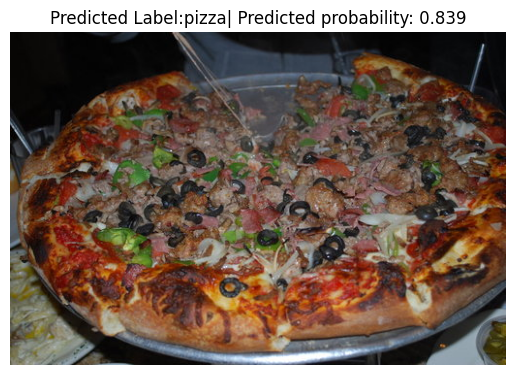

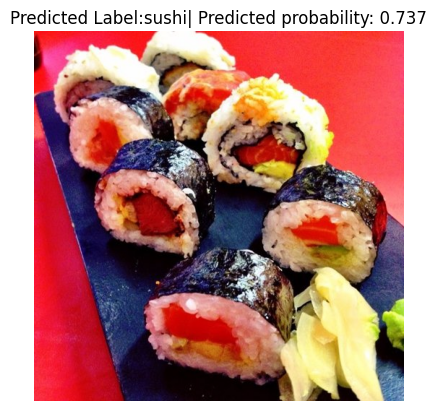

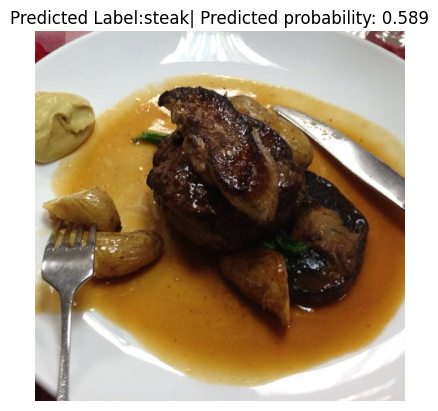

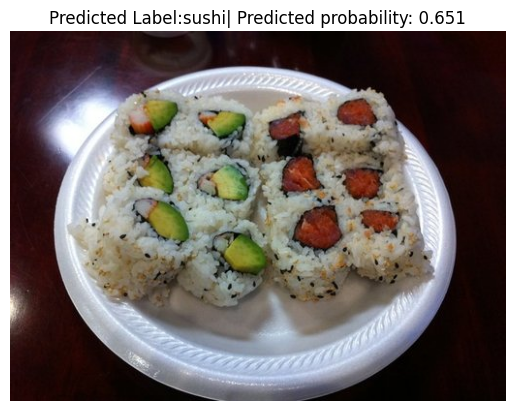

In [90]:
#getting list of random images from data
import random
image_path_list=list(Path(test_dir).glob("*/*.jpg"))
num_of_images=4
images_sample=random.sample(population=image_path_list,
                            k=num_of_images)

#call pred_and_plot_image() function for each image in above list
for image_path in images_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names
                      )

Predicting on an image from outside the database

data/04-pizza-dad.jpeg already exists, skipping download.


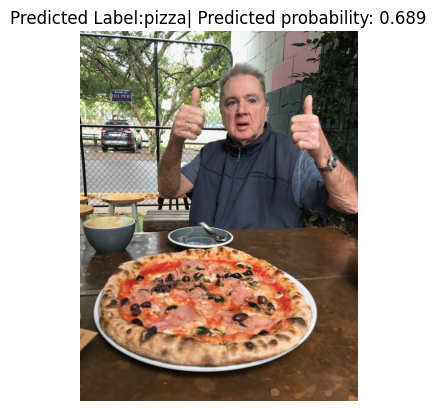

In [91]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

pred_and_plot_image(model=model, image_path=custom_image_path, class_names=class_names)

Plot Confusion Matrix

In [ ]:
from

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confusion_matrix_tensor=ConfusionMatrix(num_classes=len(class_names), task='multiclass', )